[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Discrete Bayes Filter

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division, print_function
import matplotlib.pyplot as plt
from book_format import load_style, figsize, set_figsize
load_style()

The Kalman filter belongs to a family of filters called *Bayesian filters*. Most textbook treatments of the Kalman filter present the Bayesian formula, perhaps shows how it factors into the Kalman filter equations, but mostly keeps the discussion at a very abstract level. 

That approach requires a fairly sophisticated understanding of several fields of mathematics, and it still leaves much of the work of understanding and forming an intuitive grasp of the situation in the hands of the reader.

I will use a different way to develop the topic, to which I owe the work of Dieter Fox and Sebastian Thrun a great debt. It depends on building an intuition on how Bayesian statistics work by tracking an object through a hallway - they use a robot, I use a dog (I like dogs). The first published example of this that I can find seems to be Fox 1999 [1], with a fuller example in Fox [2] 2003. Sebastian Thrun also uses this formulation in his excellent Coursera course Artificial Intelligence for Robotics [3] In fact, if you like watching videos, I highly recommend pausing reading this book in favor of first few lessons of that course, and then come back to this book for a deeper dive into the topic.

Let's now use a simple thought experiment, much like we did with the g-h filter, to see how we might reason about the use of probabilities for filtering and tracking.

## Tracking a Dog

Let us begin with a simple problem. We have a dog friendly workspace, and so people bring their dogs to work. However, occasionally the dogs wander out of your office and down the halls. We want to be able to track them. So during a hackathon somebody created a little sonar sensor to attach to the dog's collar. It emits a signal, listens for the echo, and based on how quickly an echo comes back we can tell whether the dog is in front of an open doorway or not. It also senses when the dog walks, and reports in which direction the dog has moved. It connects to our network via wifi and sends an update once a second.

I want to track my dog Simon, so I attach the device to his collar and then fire up Python, ready to try to write code to track him through the building. At first blush this may appear impossible. If I start listening to the sensor of Simon's collar I might read 'door', 'hall', 'hall', and so on. How can I use that information to determine where Simon is?

To keep the problem small, we will assume that there are only 10 positions in a single hallway to consider, which we will number 0 to 9, where 1 is to the right of 0, 2 is to the right of 1, and so on. For reasons that will be clear later, we will also assume that the hallway is circular or rectangular. If you move right from position 9, you will be at position 0.  

When I begin listening to the sensor I have no reason to believe that Simon is at any particular position in the hallway. He is equally likely to be in any position. Their are 10 positions, so the probability that he is in any given position is 1/10. 

Let's represent our belief of his position at any time in a NumPy array.

In [2]:
import numpy as np

pos_belief = np.array([.1, .1, .1, .1, .1, .1, .1, .1, .1, .1])

Now let's create a map of the hallway in another list. Suppose there are first two doors close together, and then another door quite a bit further down the hallway. We will use 1 to denote a door, and 0 to denote a wall:

In [3]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

So I start listening to Simon's transmissions on the network, and the first data I get from the sensor is "door". From this I conclude that he is in front of a door, but which one? I have no idea. I have no reason to believe he is is in front of the first, second, or third door. But what I can do is assign a probability to each door. All doors are equally likely, and there are three of them, so I assign a probability of 1/3 to each door. 

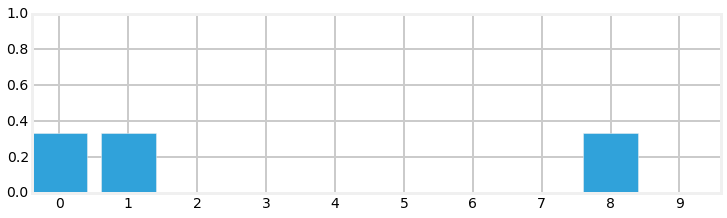

In [4]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import book_plots as bp
import numpy as np

pos_belief = np.array([1./3, 1./3, 0, 0, 0, 0, 0, 0, 1./3, 0])

set_figsize(y=3)
bp.bar_plot(pos_belief)

We call this a <i>multimodal</i> distribution because we have multiple beliefs about the position of our dog. Of course we are not saying that we think he is simultaneously in three different locations, merely that so far we have narrowed down our knowledge in his position to be one of these three locations. 

I hand coded the `pos_belief` array in the code above. How would we implement this in code? Well, hallway represents each door as a 1, and wall as 0, so we will multiply the hallway variable by the percentage, like so;

In [5]:
pos_belief = hallway * (1/3)
np.set_printoptions(precision=3)
print(pos_belief)

[ 0.333  0.333  0.     0.     0.     0.     0.     0.     0.333  0.   ]


## Extracting Information from Multiple Sensor Readings

Let's put Python aside and think about the problem a bit. Suppose we were to read the following from Simon's sensor:

  * door
  * move right
  * door
  

Can we deduce where Simon is at the end of that sequence? Of course! Given the hallway's layout there is only one place where you can be in front of a door, move once to the right, and be in front of another door, and that is at the left end. Therefore we can confidently state that Simon is in front of the second doorway. If this is not clear, suppose Simon had started at the second or third door. After moving to the right, his sensor would have returned 'wall'. That doesn't match the sensor readings, so we know he didn't start there. We can continue with that logic for all the remaining starting positions. Therefore the only possibility is that he is now in front of the second door. We denote this in Python with:

In [6]:
pos_belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
print(pos_belief)

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


Obviously I carefully constructed the hallway layout and sensor readings to give us an exact answer quickly. Real problems will not be so clear cut. But this should trigger your intuition - the first sensor reading only gave us very low probabilities (0.333) for Simon's location, but after a position update and another sensor reading we knew much more about where he is. You might suspect, correctly, that if you had a very long hallway with a large number of doors that after several sensor readings and positions updates we would either be able to know where Simon was, or have the possibilities narrowed down to a small number of possibilities. For example, suppose we had a long sequence of "door, right, door, right, wall, right, wall, right, door, right, door, right, wall, right, wall, right, wall, right, wall, right, door". Simon could only have started in a location  where his movements had a door sequence of [1,1,0,0,1,1,0,0,0,0,1] in the hallway. There might be only one match for that, or at most a few. Either way we will be far more certain about his position then when we started.

We could work through the code to implement this solution, but instead let us consider a real world complication to the problem.

## Noisy Sensors

Unfortunately I have yet to come across a perfect sensor. Perhaps the sensor would not detect a door if Simon sat in front of it while scratching himself, or it might report there is a door if he is facing towards the wall, not down the hallway. So in practice when I get a report 'door' I cannot assign 1/3 as the probability for each door. I have to assign something less than 1/3 to each door, and then assign a small probability to each blank wall position. At this point it doesn't matter exactly what numbers we assign; let us say that the probably of 'door' being correct is 0.6, and the probability of being incorrect is 0.2, which is another way of saying it is about 3 times more likely to be right than wrong. How would we do this?

At first this may seem like an insurmountable problem. If the sensor is noisy it casts doubt on every piece of data. How can we conclude anything if we are always unsure?

The key, as with the problem above, is probabilities. We are already comfortable with assigning a probabilistic belief about the location of the dog; now we just have to incorporate the additional uncertainty caused by the sensor noise. Say we think there is a 50% chance that our dog is in front of a specific door and then we get a reading of 'door'. Well, we think that is only likely to be true 0.6 of the time, so we multiply: $0.5 * 0.6= 0.3$. Likewise, if we think the chances that our dog is in front of a wall is 0.1, and the reading is 'door', we would multiply the probability by the chances of a miss: $0.1 * 0.2 = 0.02$.

However, we more or less chose 0.6 and 0.2 at random; if we multiply the `pos_belief` array by these values the end result will no longer represent a true probability distribution. 

[ 0.12  0.12  0.04  0.04  0.04  0.04  0.04  0.04  0.12  0.04]
sum = 0.64


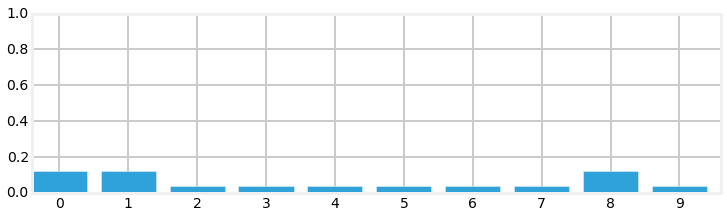

In [7]:
def update(hallway, pos_belief, measure, p_hit, p_miss):
    for i in range(len(hallway)):
        if hallway[i] == measure:
            pos_belief[i] *= p_hit
        else:
            pos_belief[i] *= p_miss

pos_belief = np.array([0.2] * 10)
reading = 1 # 1 is 'door'
update(hallway, pos_belief, 1, .6, .2)

print(pos_belief)
print('sum =', sum(pos_belief))
bp.bar_plot(pos_belief)

We can see that this is not a probability distribution because it does not sum to 1.0. But we can see that the code is doing mostly the right thing - the doors are assigned a number (0.12) that is 3 times higher than the walls (0.04). So we can write a bit of code to normalize the result so that the probabilities correctly sum to 1.0.

sum = 1.0
probability of door = 0.1875
probability of wall = 0.0625


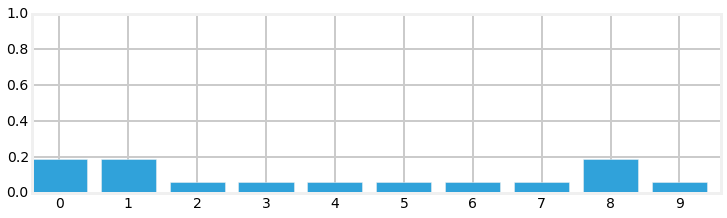

In [9]:
def update(hallway, pos_belief, measure, p_hit, p_miss):
    for i in range(len(hallway)):
        if hallway[i] == measure:
            pos_belief[i] *= p_hit
        else:
            pos_belief[i] *= p_miss
            
    pos_belief /= sum(pos_belief)

pos_belief = np.array([0.2] * 10)
reading = 1 # 1 is 'door'
update(hallway, pos_belief, 1, .6, .2)

print('sum =', sum(pos_belief))
print('probability of door =', pos_belief[0])
print('probability of wall =', pos_belief[2])
bp.bar_plot(pos_belief)

Normalization is done by dividing each element by the sum of all elements in the list. If this is not clear you should spend a few minutes proving it to yourself algebraically. We can see from the output that the sum is now 1.0, and that the probability of a door vs wall is still three times larger. The result also fits our intuition that the probability of a door must be less than 0.333, and that the probability of a wall must be greater than 0.0. Finally, it should fit our intuition that we have not yet been given any information that would allow us to distinguish between any given door or wall position, so all door positions should have the same value, and the same should be true for wall positions. 

## Incorporating Movement Data

Recall how quickly we were able to find an exact solution to our dog's position when we incorporated a series of measurements and movement updates. However, that occurred in a fictional world of perfect sensors. Might we be able to find an exact solution even in the presence of noisy sensors?

Unfortunately, the answer is no. Even if the sensor readings perfectly match an extremely complicated hallway map we could not say that we are 100% sure that the dog is in a specific position - there is, after all, the possibility that every sensor reading was wrong! Naturally, in a more typical situation most sensor readings will be correct, and we might be close to 100% sure of our answer, but never 100% sure. This may seem complicated, but lets just go ahead and program the math, which as we have seen is quite simple.

First let's deal with the simple case - assume the movement sensor is perfect, and it reports that the dog has moved one space to the right. How would we alter our `pos_belief` array?

I hope after a moment's thought it is clear that we should just shift all the values one space to the right. If we previously thought there was  a 50% chance of Simon being at position 3, then after the move to the right we should believe that there is a 50% chance he is at position 4. So let's implement that. Recall that the hallway is circular, so we will use modulo arithmetic to perform the shift correctly

belief before predict = [ 0.4  0.1  0.2  0.3]
belief after predict = [ 0.3  0.4  0.1  0.2]


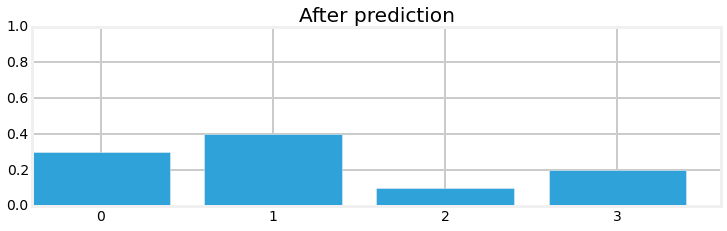

In [10]:
import numpy
def perfect_predict(pos_belief, move):
    """ move the position by 'move' spaces, where positive is to the right, 
    and negative is to the left
    """
    n = len(pos_belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = pos_belief[(i-move) % n]
    pos_belief[:] = result
        
pos_belief = np.array([.4, .1, .2, .3])
print('belief before predict =', pos_belief)
bp.bar_plot(pos_belief, title='Before prediction')

perfect_predict(pos_belief, 1)
print('belief after predict =', pos_belief)
bp.bar_plot(pos_belief, title='After prediction')

We can see that we correctly shifted all values one position to the right, wrapping from the end of the array back to the beginning.

## Adding Noise to the Prediction

We want to solve real world problems, and we have already stated that all sensors have noise. Therefore the code above must be wrong since it assumes perfect measurements. What if the sensor reported that our dog moved one space, but he actually moved two spaces, or zero? Once again this may initially sound like an insurmountable problem, but let's just model it in math. Since this is just an example, we will create a pretty simple noise model for the sensor - later in the book we will handle far more sophisticated errors.

We will say that when the sensor sends a movement update, it is 80% likely to be right, and it is 10% likely to overshoot one position to the right, and 10% likely to undershoot to the left. That is, if we say the movement was 4 (meaning 4 spaces to the right), the dog is 80% likely to have moved 4 spaces to the right, 10% to have moved 3 spaces, and 10% to have moved 5 spaces.

This is slightly harder than the math we have done so far, but it is still tractable. Each result in the array now needs to incorporate probabilities for 3 different situations. For example, consider position 9 for the case where the reported movement is 2. It should be clear that after the move we need to incorporate the probability that was at position 7 (9-2). However, there is a small chance that our dog actually moved from either 1 or 3 spaces away due to the sensor noise, so we also need to use positions 6 and 8. How much? Well, we have the probabilities, so we can just multiply and add. It would be 80% of position 7 plus 10% of position 6 and 10% of position 8! Let's try coding that:

[ 0.   0.   0.   0.   0.1  0.8  0.1  0. ]


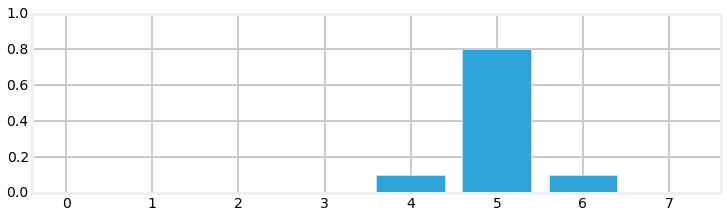

In [11]:
def predict(pos_belief, move, p_correct, p_under, p_over):
    n = len(pos_belief)
    result = np.zeros(n)
    for i in range(n):
                result[i] = (
            pos_belief[(i-move) % n]   * p_correct +
            pos_belief[(i-move-1) % n] * p_over +
            pos_belief[(i-move+1) % n] * p_under)      
    pos_belief[:] = result

pos_belief = np.array([0, 0, 0, 1, 0, 0, 0, 0], dtype=float)
predict(pos_belief, 2, .8, .1, .1)
print(pos_belief)
bp.bar_plot(pos_belief)

The simple test case that we ran appears to work correctly. We initially believed that the dog was in position 3 with 100% certainty; after the movement update we now give an 80% probability to the dog being in position 5, and a 10% chance to undershooting to position 4, and a 10% chance of overshooting to position 6. Let us look at a case where we have multiple beliefs:

[ 0.    0.    0.    0.04  0.38  0.52  0.06  0.  ]


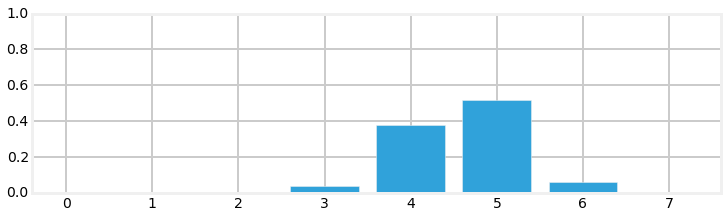

In [12]:
pos_belief = np.array([0, 0, .4, .6, 0, 0, 0, 0])
predict(pos_belief, 2, .8, .1, .1)
print(pos_belief)
bp.bar_plot(pos_belief)

Here the results are more complicated, but you should still be able to work it out in your head. The 0.04 is due to the possibility that the 0.4 belief undershot by 1. The 0.38 is due to the following: the 80% chance that we moved 2 positions $(.4 * .8)$ and the 10% chance that we undershot $(.6*.1)$. Overshooting plays no role here because if we overshot both .4 and .6 would be past this position. **I strongly suggest working some examples until all of this is very clear, as so much of what follows depends on understanding this step.**

If you look at the probabilities after performing the update you probably feel dismay. In the example above we started with probabilities of .4 and .6 in two fields; after performing the update the probabilities are not only lowered, but they are strewn out across the map.

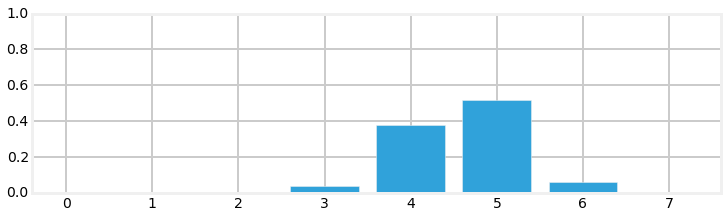

In [13]:
bp.bar_plot(pos_belief)

This is not a coincidence, or the result of a carefully chosen example - it is always true of the predict step. This is inevitable; if our sensor is noisy we will lose a bit of information on every prediction. Suppose we were to perform the prediction an infinite number of times - what would the result be? If we lose information on every step, we must eventually end up with no information at all, and our probabilities will be equally distributed across the `pos_belief` array. Let's try this with 500 iterations.


[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


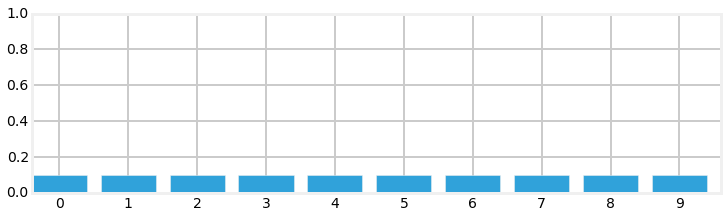

In [14]:
pos_belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
for i in range(500):
    predict(pos_belief, 1, .8, .1, .1)
print(pos_belief)
bp.bar_plot(pos_belief)


After 500 iterations we have lost all information, even though we were 100% sure that we started in position 1. Feel free to play with the numbers to see the effect of differing number of updates. For example, after 100 updates we have a small amount of information left.


And, if you are viewing this on the web or in IPython Notebook, here is an animation of that output.
<img src="animations/02_no_info.gif">

## Integrating Measurements and Movement Updates

The problem of losing information during a prediction may make it seem as if our system would quickly devolve into no knowledge. However, recall that our process is not an endless series of predictions, but of *update->predict->update->predict->update->predict->update...* The output of the update step, where we measure the current position, is fed into the prediction. The prediction step, with a degraded certainty, is then fed back into the update step where we measure the position again.

Let's think about this intuitively. After the first update->predict round we have degraded the knowledge we gained by the measurement by a small amount. But now we take another measurement. When we try to incorporate that new measurement into our belief, do we become more certain, less certain, or equally certain? Consider a simple case - you are sitting in your office. A co-worker asks another co-worker where you are, and they report "in his office". You keep sitting there while they ask and answer "has he moved"? "No" "Where is he" "In his office". Eventually you get up and move, and lets say the person didn't see you move. At that time the questions will go "Has he moved" "no" (but you have!) "Where is he" "In the kitchen". Wow! At that moment the statement that you haven't moved conflicts strongly with the next measurement that you are in the kitchen. If we were modeling these with probabilities the probability that you are in your office would lower, and the probability that you are in the kitchen would go up a little bit. But now imagine the subsequent conversation: "has he moved" "no" "where is he" "in the kitchen". Pretty quickly the belief that you are in your office would fade away, and the belief that you are in the kitchen would increase to near certainty. The belief that you are in the office will never go to zero, nor will the belief that you are in the kitchen ever go to 1.0 because of the chances of error, but in practice your co-workers would be correct to be quite confident in their system.

That is what intuition tells us. What does the math tell us?

Well, we have already programmed the update step, and we have programmed the predict step. All we need to do is feed the result of one into the other, and we will have programmed our dog tracker!!! Let's see how it performs. We will input measurements as if the dog started at position 0 and moved right at each update. However, as in a real world application, we will start with no knowledge and assign equal probability to all positions. 

In [15]:
pos_belief = np.array([.1] * 10)
update(hallway, pos_belief, 1, .6, .2)
print(pos_belief)

[ 0.187  0.187  0.062  0.062  0.062  0.062  0.062  0.062  0.187  0.062]


[ 0.087  0.175  0.175  0.075  0.062  0.062  0.062  0.062  0.075  0.162]


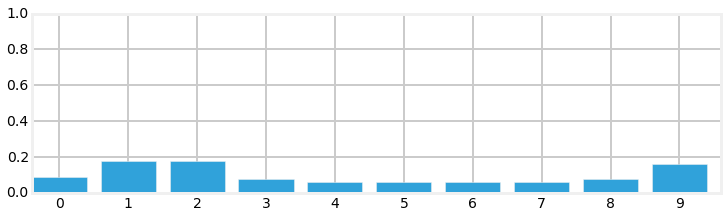

In [16]:
predict(pos_belief, 1, .8, .1, .1)
print(pos_belief)
bp.bar_plot(pos_belief)

So after the first update we have assigned a high probability to each door position, and a low probability to each wall position. The predict step shifted these probabilities to the right, smearing them about a bit. Now let's look at what happens at the next sense.

[ 0.157  0.313  0.104  0.045  0.037  0.037  0.037  0.037  0.134  0.097]


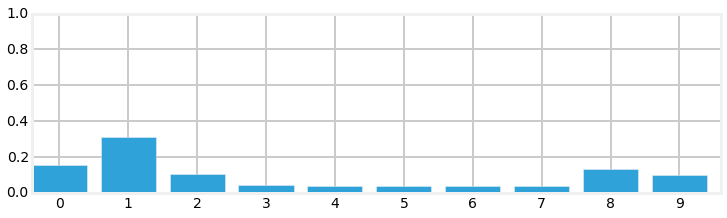

In [17]:
update(hallway, pos_belief, 1, .6, .2)
print(pos_belief)
bp.bar_plot(pos_belief)

Notice the tall bar at position 1. This corresponds with the (correct) case of starting at position 0, sensing a door, shifting 1 to the right, and sensing another door. No other positions make this set of observations as likely. Now lets add an update and then sense the wall.

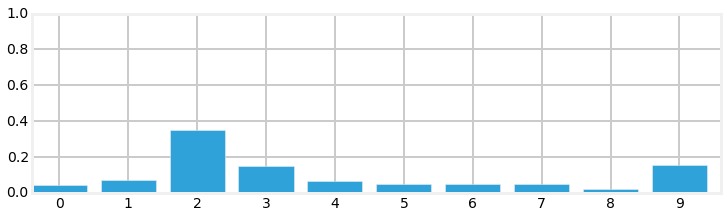

In [18]:
predict(pos_belief, 1, .8, .1, .1)
update(hallway, pos_belief, 0, .6, .2)
bp.bar_plot(pos_belief)

This is exciting! We have a very prominent bar at position 2 with a value of around 35%. It is over twice the value of any other bar in the plot, and is about 4% larger than our last plot, where the tallest bar was around 31%. Let's see one more sense->update cycle.

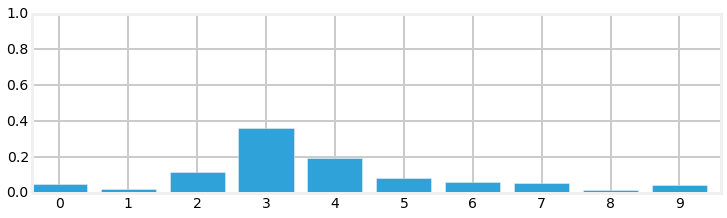

In [19]:
predict(pos_belief, 1, .8, .1, .1)
update(hallway, pos_belief, 0, .6, .2)
bp.bar_plot(pos_belief)

Here things have degraded a bit due to the long string of wall positions in the map. We cannot be as sure where we are when there is an undifferentiated line of wall positions, so naturally our probabilities spread out a bit.

Finally, for those viewing this in a Notebook or on the web, here is an animation of that algorithm.
<img src="animations/02_simulate.gif">

## The Effect of Bad Sensor Data

You may be suspicious of the results above because I always passed correct sensor data into the functions. However, we are claiming that this code implements a *filter* - it should filter out bad sensor measurements. Does it do that?

To make this easy to program and visualize I will change the layout of the hallway to mostly alternating doors and hallways, and run the algorithm on 5 correct measurements:

[ 0.225  0.063  0.061  0.058  0.093  0.225  0.063  0.061  0.058  0.093]


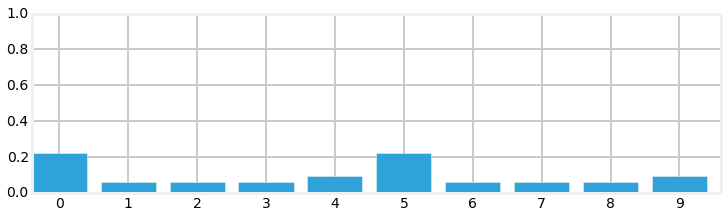

In [20]:
hallway = [1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
pos_belief = np.array([.1] * 10)
measurements = [1, 0, 1, 0, 0]

for m in measurements:
    update(hallway, pos_belief, m, .6, .2)
    predict(pos_belief, 1, .8, .1, .1)
bp.bar_plot(pos_belief)
print(pos_belief)

At this point we have correctly identified the likely cases, we either started at position 0 or 5, because we saw the following sequence of doors and walls 1,0,1,0,0. But now lets inject a bad measurement, and see what happens:


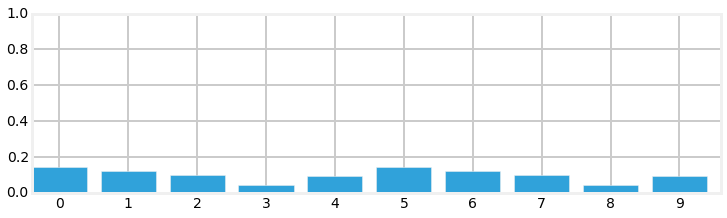

In [21]:
update(hallway, pos_belief, m, .6, .2)
predict(pos_belief, 1, .8, .1, .1)
bp.bar_plot(pos_belief)

That one bad measurement appears to have significantly eroded our knowledge. However, note that our highest probabilities are still at 0 and 5, which is correct. Now let's continue with a series of correct measurements

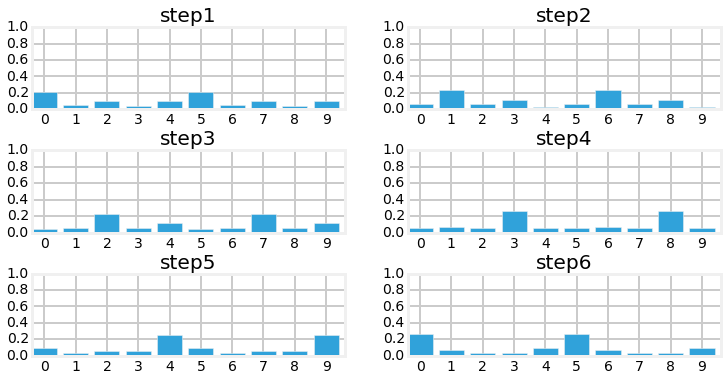

In [24]:
with figsize(y=5.5):
    measurements = [0, 1, 0, 1, 0, 0]

    for i, m in enumerate(measurements):
        update(hallway, pos_belief, m, .6, .2)
        predict(pos_belief, 1, .8, .1, .1)
        plt.subplot(3, 2, i+1)
        bp.bar_plot(pos_belief, title='step{}'.format(i+1))

As you can see we quickly filtered out the bad sensor reading and converged on the most likely positions for our dog.

## Drawbacks and Limitations

Do not be mislead by the simplicity of the examples I chose. This is a robust and complete implementation of a histogram filter, and you may use the code in real world solutions. If you need a multimodal, discrete filter, this filter works.

With that said, while this filter is used in industry, it is not used often because it has several limitations. Getting around those limitations is the motivation behind the chapters in the rest of this book.

The first problem is scaling. Our dog tracking problem used only one variable, $pos$, to denote the dog's position. Most interesting problems will want to track several things in a large space. Realistically, at a minimum we would want to track our dogs $(x,y)$ coordinate, and probably his velocity $(\dot{x},\dot{y})$ as well. We have not covered the multidimensional case, but instead of a histogram we use a multidimensional grid to store the probabilities at each discrete location. Each `update()` and `predict()` step requires updating all values in the grid, so a simple four variable problem would require $O(n^4)$ running time *per time step*. Realistic filters can have 10 or more variables to track, leading to exorbitant computation requirements.

The second problem is that the histogram is discrete, but we live in a continuous world. The histogram requires that you model the output of your filter as a set of discrete points. In our dog in the hallway example, we used 10 positions, which is obviously far too few positions for anything but a toy problem. For example, for a 100 meter hallway you would need 10,000 positions to model the hallway to 1cm accuracy. So each update and predict operation would entail performing calculations for 10,000 different probabilities. It gets exponentially worse as we add dimensions. If our dog was roaming in a $100x100 m^2$ courtyard, we would need 100,000,000 bins ($10,000^2$) to get 1cm accuracy.

A third problem is that the histogram is multimodal. This is not always a problem - an entire class of filters, the particle filters, are multimodal and are often used because of this property. But imagine if the GPS in your car reported to you that it is 40% sure that you are on D street, but 30% sure you are on Willow Avenue. I doubt that you would find that useful. Also, GPSs report their error - they might report that you are at $(109.878W, 38.326N)$ with an error of $9m$. There is no clear mathematical way to extract error information from a histogram. Heuristics suggest themselves to be sure, but there is no exact determination. You may or may not care about that while driving, but you surely do care if you are trying to send a rocket to Mars or track and hit an oncoming missile.

This difficulty is related to the fact that the filter often does not represent what is physically occurring in the world. Consider this distribution for our dog:

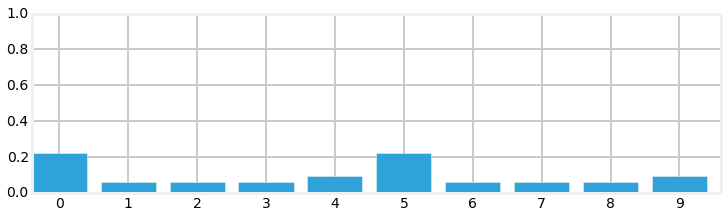

In [25]:
pos_belief = [0.2245871, 0.06288015, 0.06109133, 0.0581008, 0.09334062, 
              0.2245871, 0.06288015, 0.06109133, 0.0581008, 0.09334062]
bp.bar_plot(pos_belief)  

 The largest probabilities are in position 0 and position 5. This does not fit our physical intuition at all. A dog cannot be in two places at once (my dog Simon certainly tries - his food bowl and my lap often have equal allure to him). We would have to use heuristics to decide how to interpret this distribution, and there is usually no satisfactory answer. This is not always a weakness - a considerable amount of literature has been written on *Multi-Hypothesis Tracking (MHT)*. We cannot always distill our knowledge to one conclusion, and MHT uses various techniques to maintain multiple story lines at once, using backtracking schemes to go *back in time* to correct hypothesis once more information is known. This will be the subject of later chapters. In other cases we truly have a multimodal situation - we may be optically tracking pedestrians on the street and need to represent all of their positions. 
 
In practice it is the exponential increase in computation time that leads to the discrete Bayes filter being the least frequently used of all filters in this book. Many problems are best formulated as discrete or multimodal, but we have other filter choices with better performance. With that said, if I had a small problem that this technique could handle I would choose to use it; it is trivial to implement, debug, and understand, all virtues.

## Tracking and Control

So far we have been tracking an object which is moving independently. But consider this very similar problem. I am automating a warehouse and want to use robots to collect all of the items for a customer's order. Perhaps the easiest way to do this is to have the robots travel on a train track. I want to be able to send the robot a destination and have it go correctly to that point. But train tracks and robot motors are imperfect. Wheel slippage and imperfect motors means that the robot is unlikely to travel to exactly the position you command. 

So, we add sensors. Our budget is limited, and Hall sensors are cheap (they detect when proximity to magnets), so we line the track with magnets in some non-uniform pattern and put a cheap Hall sensor on the robot. You already see where this is going. The hall sensor reports whether the robot is near a magnet or not, and using the code above we can determine the position of our robot.

But we are not done. A key lesson from the g-h filters chapter is to never throw information away. If you have information you should use it to improve your knowledge. What information are we leaving out? Well, we know what our destination is, and we know what control inputs we are feeding to the wheels of the robot at each moment in time. For example, let's say that once a second we send a movement command to the robot - move left 1 unit, move right 1 unit, or stand still. This is obviously a simplification because I am not taking acceleration into account, but I am not trying to teach control theory here. If I send the command 'move left 1 unit' I expect that in one second from now the robot will be 1 unit to the left of where it is now. But, wheels and motors are imperfect. We will assume that it never makes a mistake and goes right when told to go left, so the errors should be relatively small. Thus the robot might end up 0.9 units away, or maybe 1.2 units away. 

Now the entire solution is clear. For the dog which was moving independently we assumed that he kept moving in whatever direction he was previously moving. That is a dubious assumption for my dog! Robots are far more predictable. Instead of feeding in a dubious prediction based on assumption of behavior we will feed in the command that we sent to the robot! 

### Simulating the Train Behavior

To fully implement this filter we need to simulate an imperfect train. When we command it to move it will sometimes make a small mistake, and it's sensor will sometimes return the incorrect value.

In [191]:
import random

class Train(object):
    
    def __init__(self, track, move_error=.1, sense_error=.1, no_sense_error=.05):
        self.track = track 
        self.pos = 0
        self.move_error = move_error
        self.sense_error = sense_error
        self.no_sense_error = no_sense_error
        
        
    def move(self, distance=1, left=True):
        """ move in the specified direction with some small chance of error"""
        if left:
            self.pos -= distance
        else:
            self.pos += distance
            
        # insert random movement error
        r = random.random()
        if r < self.move_error:
            self.pos -= 1
        elif r > 1 - self.move_error:
            self.pos += 1
            
        self.pos = self.pos % len(track)
        return self.pos
    
    def sense(self):
        at_magnet = (self.track[self.pos] == 1)
        
         # insert random sensor error
        r = random.random()
        
        if at_magnet:
            if r < self.sense_error:
                at_magnet = False
                print('sense error')
        else:
            if r < self.no_sense_error:
                at_magnet = True
                print('sense error')
        return at_magnet

With that we are ready to write the simulation. We will put it in a function so that we can run it with different assumptions. I will assume that the robot always starts at the beginning of the track. The track is implemented as being only 10 units long, but this could just represent a track of length, say 10,000, with the magnet pattern repeated every 10 units. I set the magnet pattern to first have a gap of 1 unit, then 2 units, then 3 units to help the algorithm distinguish where the robot is. 

In [218]:
def simulate(iterations, move_error, sense_error, 
             no_sense_error, move_distance,
             do_print=True):
    track = [True, False, True, False, False,
             True, False, False, False, True]

    pos_belief = np.array([0.01] * 10)
    pos_belief[0] = .9
    
    p_correct = 1 - move_error

    robot = Train(track, move_error, sense_error, no_sense_error)

    for i in range(iterations):
        robot.move(distance=move_distance, left=False)
        m = robot.sense()
        if do_print:
            print('time {}: pos {}, sense {}, at magnet {}'.format(
                    i, robot.pos, m, track[robot.pos]))

        predict(pos_belief, move_distance, p_correct, move_error/2., move_error/2.)       
        if do_print:
            print('    predict', pos_belief)

        update(track, pos_belief, m, 1. - sense_error, no_sense_error)
        if do_print:
            print('    update ', pos_belief)
        ind = np.argmax(pos_belief)
        print('    predicted position is {} with confidence {:.4}%:'.format(
                ind, pos_belief[ind]*100))

            
    bp.bar_plot(pos_belief)
    print()
    print('final position is    :', robot.pos)
    i = np.argmax(pos_belief)
    print('predicted position is {} with confidence {:.4}%:'.format(
            i, pos_belief[i]*100))

Read the code and make sure you understand it. Now let's do a run with no sensor or movement error. If the code is correct it should be able to locate the robot with no error. The output is a bit tedious to read, but if you are at all unsure of how the update/predict cycle works make sure you read through it carefully to solidify your understanding.

time 0: pos 1, sense False, at magnet False
    predict [ 0.05  0.81  0.05  0.01  0.01  0.01  0.01  0.01  0.01  0.01]
    update  [ 0.    0.93  0.    0.01  0.01  0.    0.01  0.01  0.01  0.  ]
    predicted position is 1 with confidence 93.42%:
time 1: pos 2, sense True, at magnet True
    predict [ 0.    0.05  0.84  0.05  0.01  0.01  0.    0.01  0.01  0.01]
    update  [ 0.    0.    0.96  0.    0.    0.01  0.    0.    0.    0.01]
    predicted position is 2 with confidence 96.47%:
time 2: pos 3, sense False, at magnet False
    predict [ 0.01  0.    0.05  0.87  0.05  0.    0.01  0.    0.    0.  ]
    update  [ 0.    0.    0.    0.93  0.05  0.    0.01  0.    0.    0.  ]
    predicted position is 3 with confidence 92.57%:
time 3: pos 3, sense False, at magnet False
    predict [ 0.    0.    0.    0.05  0.84  0.1   0.    0.01  0.    0.  ]
    update  [ 0.    0.    0.    0.05  0.92  0.01  0.    0.01  0.    0.  ]
    predicted position is 4 with confidence 92.17%:

final position is    : 3


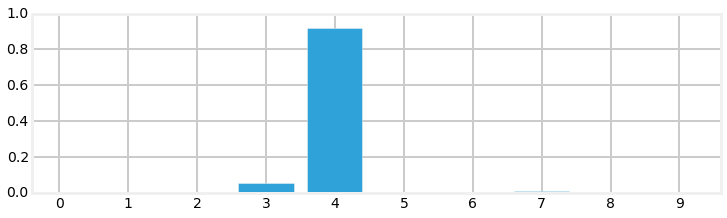

In [219]:
random.seed(3)
np.set_printoptions(precision=2)
simulate(4, move_error=0.1, sense_error=0.1,
         no_sense_error=0.05, move_distance=1,
         do_print=True)

We can see that the code was able to perfectly track the robot so we should feel reasonably confident that the code is working. Now let's see how it fairs with some errors. 

time 0: pos 3, sense False, at magnet False
    update  [ 0.    0.17  0.    0.17  0.17  0.    0.17  0.17  0.17  0.  ]
predicted position is 1 with confidence 16.67%:
    predict [ 0.17  0.16  0.01  0.01  0.15  0.02  0.16  0.16  0.02  0.16]
time 1: pos 6, sense False, at magnet False
    update  [ 0.    0.24  0.    0.01  0.23  0.    0.24  0.24  0.03  0.  ]
predicted position is 1 with confidence 24.36%:
    predict [ 0.23  0.04  0.    0.01  0.22  0.01  0.02  0.21  0.02  0.23]
time 2: pos 9, sense True, at magnet True
    update  [ 0.49  0.    0.    0.    0.    0.03  0.    0.    0.    0.48]
predicted position is 0 with confidence 48.66%:
    predict [ 0.    0.02  0.46  0.46  0.02  0.    0.    0.    0.02  0.  ]
time 3: pos 2, sense True, at magnet True
    update  [ 0.    0.    0.99  0.    0.    0.01  0.    0.    0.    0.  ]
predicted position is 2 with confidence 99.19%:
    predict [ 0.    0.    0.    0.    0.05  0.89  0.05  0.    0.    0.  ]
time 4: pos 5, sense True, at magnet True
  

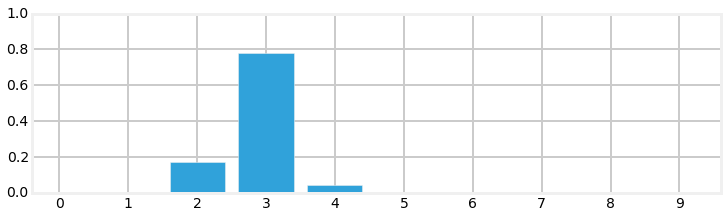

In [158]:
simulate(10, move_error=0.0, sense_error=.05,
         no_sense_error=0.05, move_distance=3)

Ypi 


final position is    : 4
predicted position is 1 with confidence 56.3%:


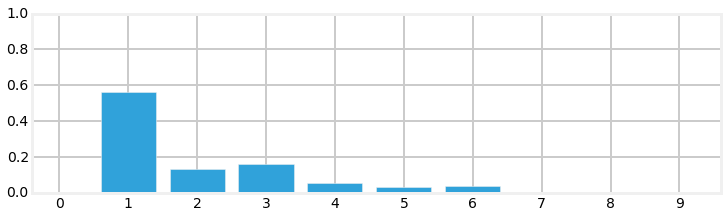

In [126]:
simulate(133, move_error=0.05, sense_error=.05,
         no_sense_error=0.05, move_distance=4, do_print=False)

## Summary

The code is very small, but the result is huge! We will go into the math more later, but we have implemented a form of a Bayesian filter. It is commonly called a Histogram filter. The Kalman filter is also a Bayesian filter, and uses this same logic to produce its results. The math is a bit more complicated, but not by much. For now, we will just explain that Bayesian statistics compute the likelihood of some estimate about the present based on imperfect knowledge of the past. If we know there are two doors in a row, and the sensor reported two doors in a row, it is likely that we are positioned near those doors. Bayesian statistics just formalize that example, and Bayesian filters formalize filtering data based on that math by implementing the predict->update->predict->update process. 

We have learned how to start with no information and derive information from noisy sensors. Even though the sensors in this chapter are very noisy (most sensors are more than 80% accurate, for example) we quickly converge on the most likely position for our dog. We have learned how the predict step always degrades our knowledge, but the addition of another measurement, even when it might have noise in it, improves our knowledge, allowing us to converge on the most likely result.

If you followed the math carefully you will realize that all of this math is exact. The bar charts that we are displaying are not an *estimate* or *guess* - they are mathematically exact results that exactly represent our knowledge. The knowledge is probabilistic, to be sure, but it is exact, and correct.

However, we are a long way from tracking an airplane or a car. This code only handles the 1 dimensional case, whereas cars and planes operate in 2 or 3 dimensions. Also, our position vector is *multimodal*. It expresses multiple beliefs at once. Imagine if your GPS told you "it's 20% likely that you are here, but 10% likely that you are on this other road, and 5% likely that you are at one of 14 other locations". That would not be very useful information. Also, the data is discrete. We split an area into 10 (or whatever) different locations, whereas in most real world applications we want to work with continuous data. We want to be able to represent moving 1 km, 1 meter, 1 mm, or any arbitrary amount, such as 2.347 cm. 

Finally, the bar charts may strike you as being a bit less certain than we would want. A 25% certainty may not give you a lot of confidence in the answer. Of course, what is important here is the ratio of this probability to the other probabilities in your vector. If the next largest bar is 23% then we are not very knowledgeable about our position, whereas if the next largest is 3% we are in fact quite certain. But this is not clear or intuitive. However, there is an extremely important insight that Kalman filters implement that will significantly improve our accuracy from the same data.


**If you can understand this chapter you will be able to understand and implement Kalman filters.** I cannot stress this enough. If anything is murky, go back and reread this chapter and play with the code. The rest of this book will build on the algorithms that we use here. If you don't intuitively understand why this histogram filter works, and can't at least work through the math, you will have little success with the rest of the material. However, if you grasp the fundamental insight - multiplying probabilities when we measure, and shifting probabilities when we update, leading to a converging solution - then you understand everything important you need to grasp the Kalman filter. 

## References

 * [1] D. Fox, W. Burgard, and S. Thrun. "Monte carlo localization: Efficient position estimation for mobile robots." In *Journal of Artifical Intelligence Research*, 1999.
 
 http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume11/fox99a-html/jair-localize.html


 * [2] Dieter Fox, et. al. "Bayesian Filters for Location Estimation". In *IEEE Pervasive Computing*, September 2003.
 
 http://swarmlab.unimaas.nl/wp-content/uploads/2012/07/fox2003bayesian.pdf
 
 
 * [3] Sebastian Thrun. "Artificial Intelligence for Robotics".
 
 https://www.udacity.com/course/cs373
 
 